# Многоклассовая классификация отзывов клиентов

Цель: построить модель для классификации негативных отзывов клиентов по трем категориям сервисов - доставка, товары, магазин 

* Метрика для оценки - f1. 

* Готовая модель должна быть сохранена в каком-либо формате. 

* В отдельном файле model.py должна храниться функция 
      def get_result(text: pd.Series) -> pd.Series:
          pass

* Функция принимает колонку с отзывами, на выходе отдает колонку с предсказанными классами. Колонка с классами должна иметь наименование - class_predicted. Функция должна вызывать обученную модель из файла, предсказывать классы и отдавать их.

# Импорт библиотек

In [2]:
import pandas as pd
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import torch
import multiprocessing
import random
import time
import pickle
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

import logging
import gensim
from gensim.models import Word2Vec

import transformers
import torch.nn as nn
from transformers import BertModel, AutoModel, AutoTokenizer, BertTokenizer, \
                        BertForSequenceClassification, AutoModelForSequenceClassification, TrainingArguments, Trainer

from pandarallel import pandarallel
from pymystem3 import Mystem
from wordcloud import WordCloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download("stopwords")

from tqdm import tqdm, notebook
tqdm.pandas()

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE, MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import f1_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge
from sklearn import svm
from lightgbm import LGBMRegressor
import xgboost as xgb

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Константы

In [4]:
russian_stopwords = stopwords.words("russian")
for i in range(len(russian_stopwords) - 1, -1, -1):
    if russian_stopwords[i] == 'не' or russian_stopwords[i] == 'нет':
        del russian_stopwords[i]
        
cores = multiprocessing.cpu_count()
random_state = 282
n_gramms_100 = (2, 2)

# Загрузка и обзор данных

In [6]:
df = pd.read_csv('data (2).csv', sep=';', on_bad_lines='skip')

In [7]:
df.head(10)

,text,class
0,Невнимательность к покупателю. Товар выносят п...,Товар
1,Посудомоечная машина не исправна. Остальной то...,Товар
2,"Приехал в магазин, оказался только Витринный о...",Товар
3,Несколько раз переносили дату доставки.,Доставка
4,"На сайте было написано бесплатная доставка,а п...",Доставка
5,На пункте выдачи нет сотрудника._x000D_\n,Магазин
6,"Продавцы не должны запугивать клиента, чтобы о...",Магазин
7,Ассортимент печальный.,Товар
8,Заказ не доставлен. По телефону сотрудница маг...,Доставка
9,"оператор не располагал данной информацией,в ма...",Магазин


In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1763 non-null   object
 1   class   1763 non-null   object
dtypes: object(2)
memory usage: 720.4 KB


Оценим сбалансированность классов:

In [9]:
df['class'].value_counts()

Доставка    793
Товар       570
Магазин     400
Name: class, dtype: int64

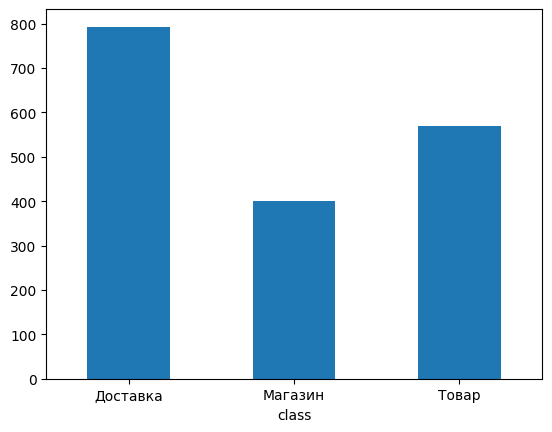

In [10]:
df.groupby('class')['text'].count().plot.bar(ylim=0)
plt.xticks(rotation=0)
plt.show()

Заменим строковые наименования категорий на численные и подготовим справочник кллассов для дальнейшего использования в chi2:

In [11]:
df['class_id'] = df['class'].factorize()[0]

In [12]:
category_to_id = {'Товар': 0,
                  'Доставка': 1,
                  'Магазин': 2}

## Обзор частых  N-грамм:

In [13]:
corpus_prod = df.loc[df['class_id'] == 0, 'text'].values
corpus_delivery = df.loc[df['class_id'] == 1, 'text'].values
corpus_shop = df.loc[df['class_id'] == 2, 'text'].values

Построим отдельно графики популярности слов в выборках для Товаров и для Доставки:

In [14]:
words_counter = CountVectorizer(ngram_range=n_gramms_100, stop_words=russian_stopwords)
wrdz_count = words_counter.fit_transform(corpus_prod)

words_frequence = pd.DataFrame(
  {'word' : words_counter.get_feature_names_out(),
  'frequency' : np.array(wrdz_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

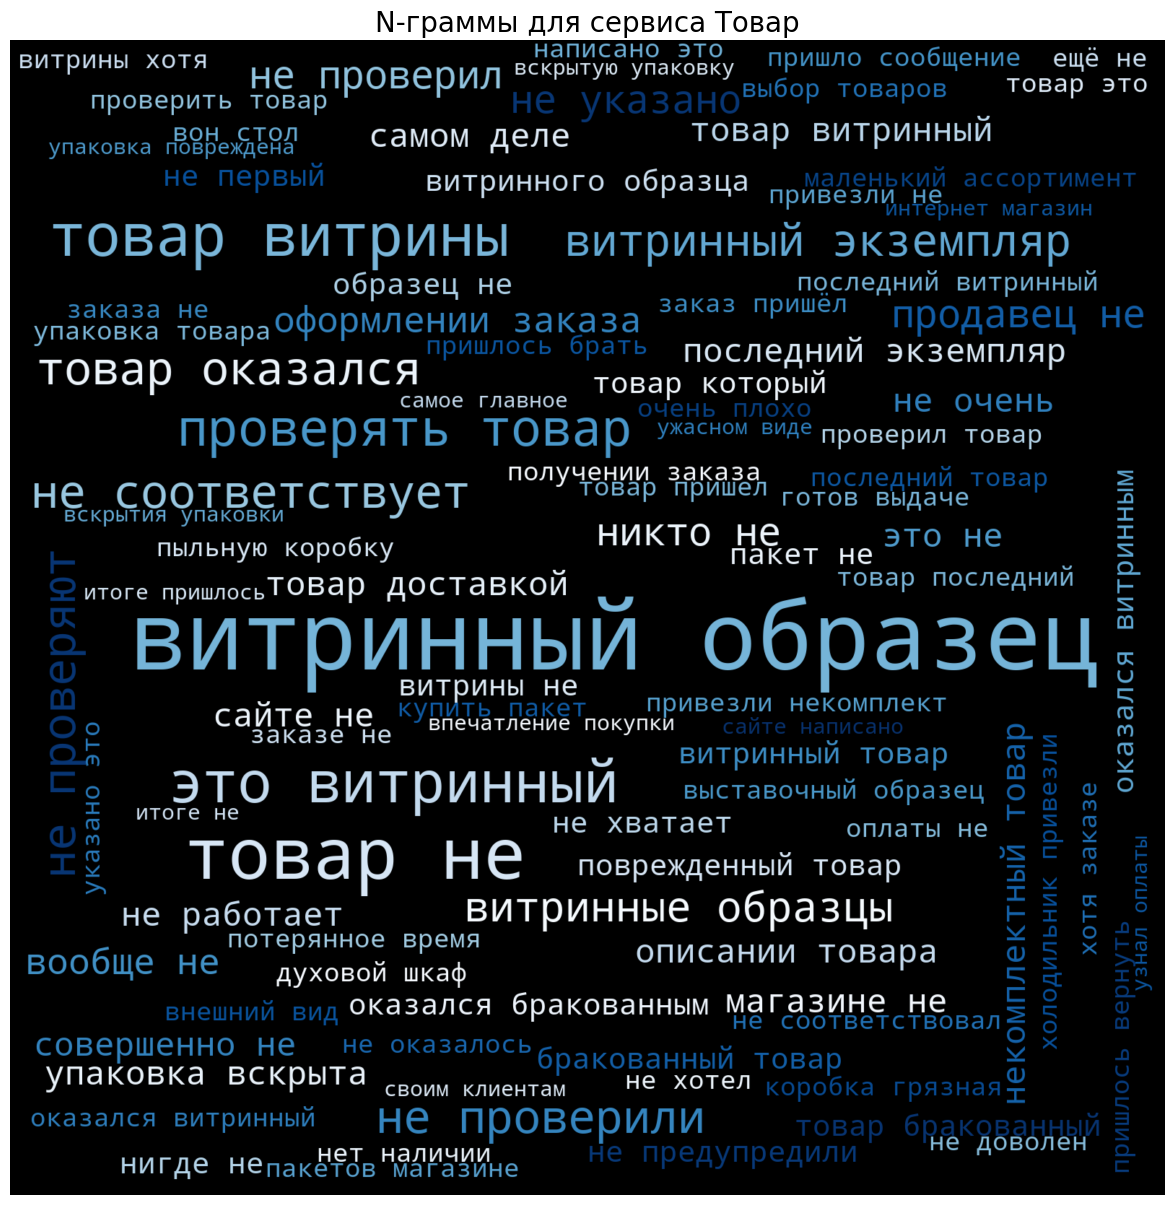

In [15]:
wordcloud_words = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=100,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(words_frequence.values))


fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(wordcloud_words, interpolation='bilinear')
ax.set_title('N-граммы для сервиса Товар', fontsize = 20)
ax.axis("off")
plt.show()

In [16]:
words_counter = CountVectorizer(ngram_range=n_gramms_100, stop_words=russian_stopwords)
wrdz_count = words_counter.fit_transform(corpus_delivery)

words_frequence = pd.DataFrame(
  {'word' : words_counter.get_feature_names_out(),
  'frequency' : np.array(wrdz_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

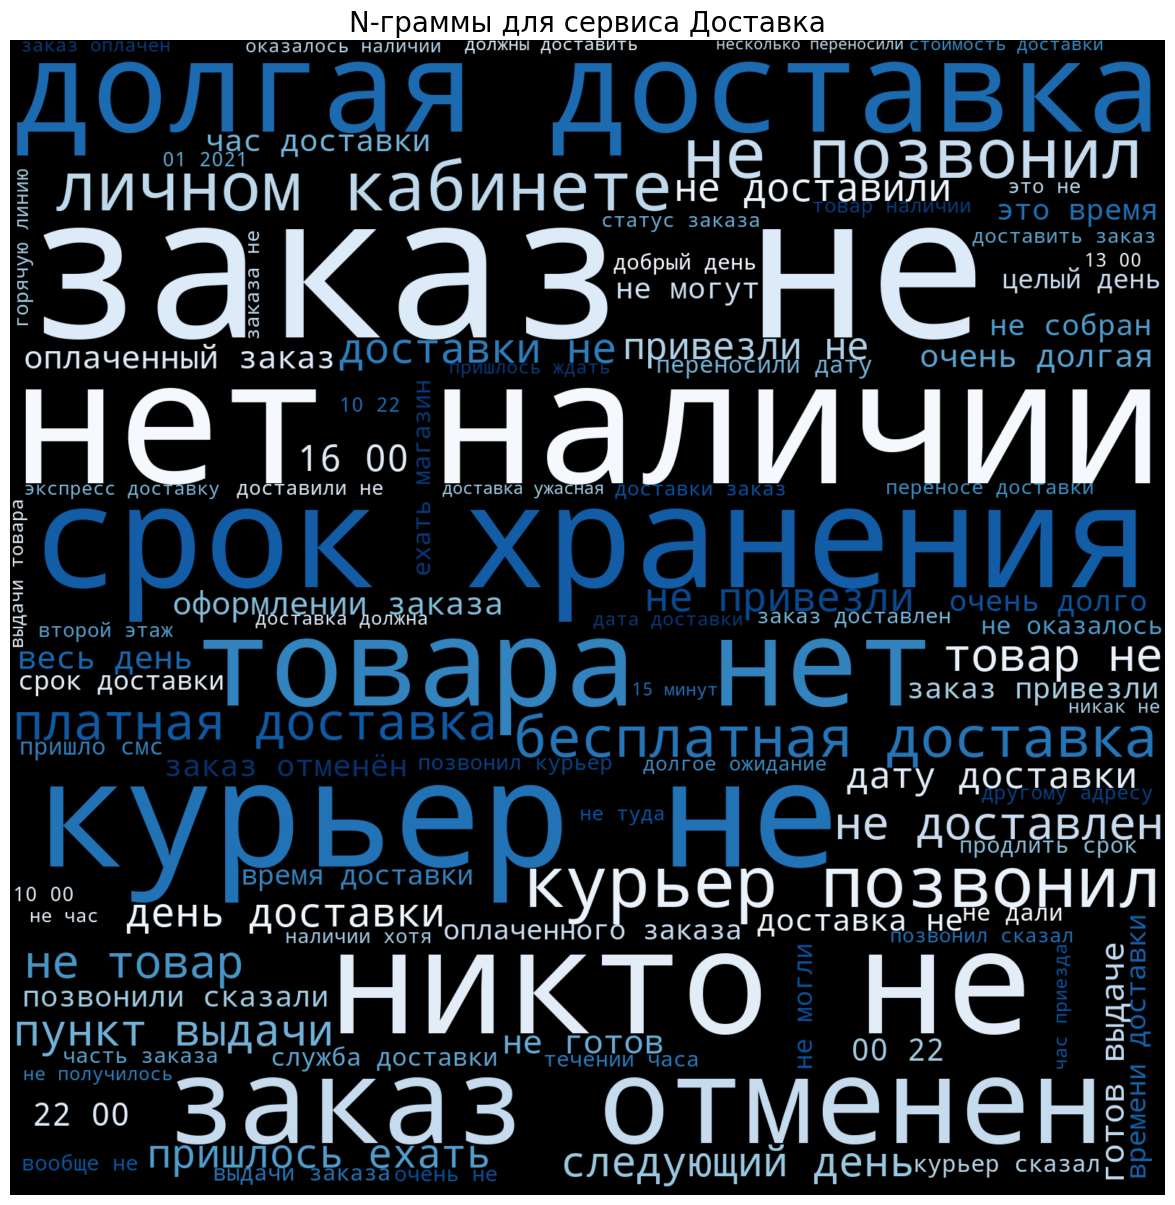

In [17]:
wordcloud_words = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=100,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(words_frequence.values))

fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(wordcloud_words, interpolation='bilinear')
ax.set_title('N-граммы для сервиса Доставка', fontsize = 20)
ax.axis("off")
plt.show()

In [18]:
words_counter = CountVectorizer(ngram_range=n_gramms_100, stop_words=russian_stopwords)
wrdz_count = words_counter.fit_transform(corpus_shop)

words_frequence = pd.DataFrame(
  {'word' : words_counter.get_feature_names_out(),
  'frequency' : np.array(wrdz_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

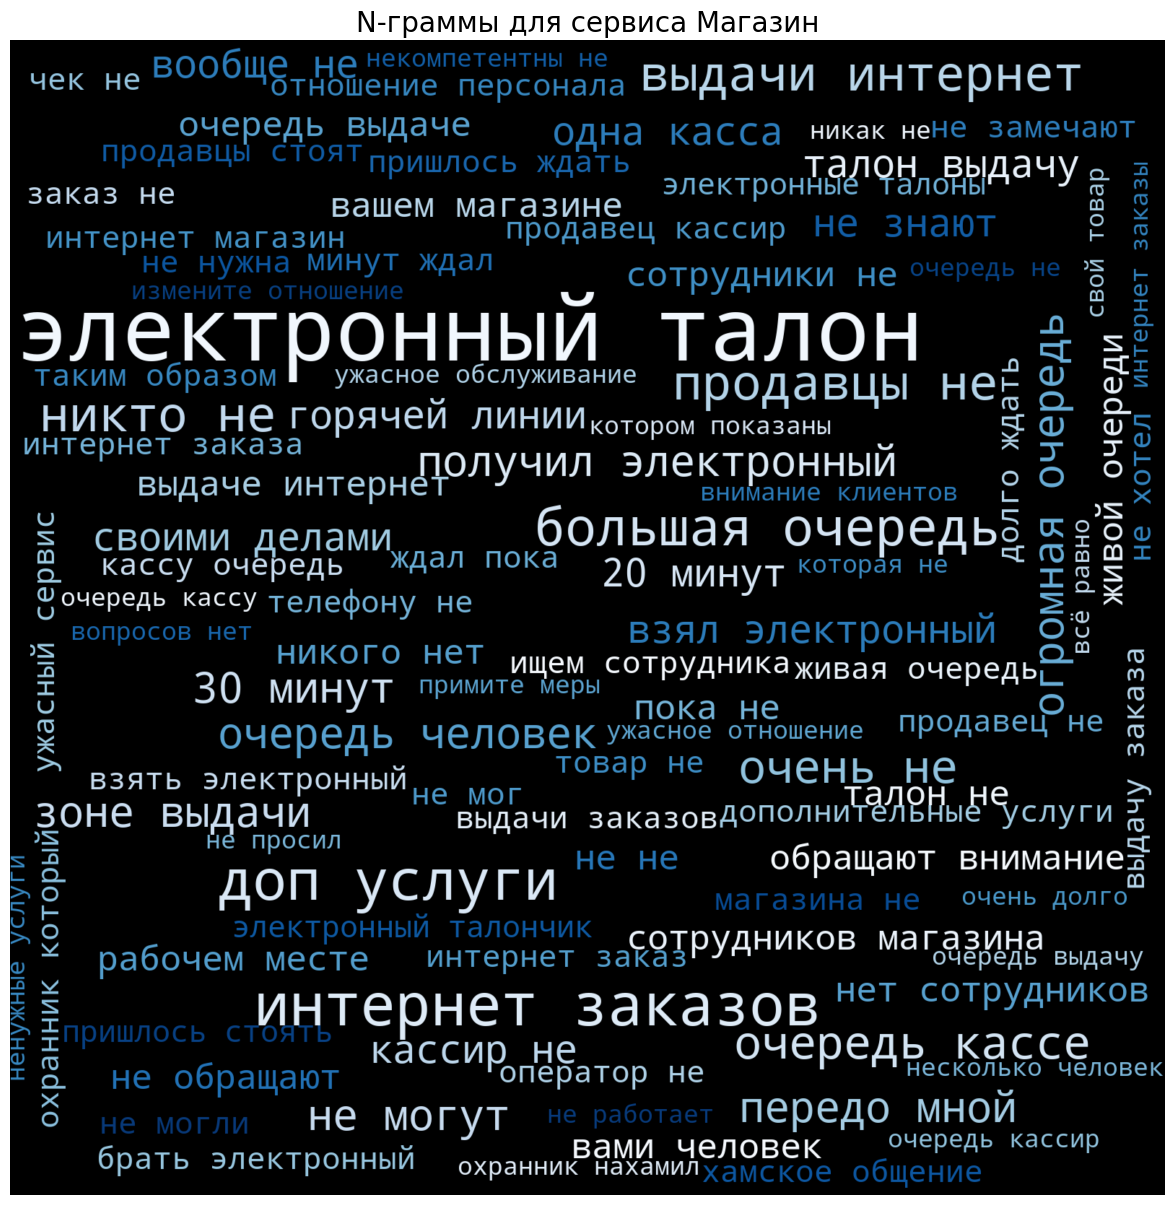

In [19]:
wordcloud_words = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=100,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(words_frequence.values))

fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(wordcloud_words, interpolation='bilinear')
ax.set_title('N-граммы для сервиса Магазин', fontsize = 20)
ax.axis("off")
plt.show()

**Вывод:** 
1. Выполнен обзор датасета. Пропуски отсутствуют, дубликаты не проверяем т.к. короткие отзывы могут повторяться, классы (в количестве 3 шт.) сбалансированы
2. Данные подготовлены для анализа: лемматизированы, очищены от символов и знаков пунктуации
3. Выполнен обзор уни- и би-грамм по тегам классов

# Подготовка датасета

## Лемматизации и очистка датасета

Подготовим функцию для очистки корпуса текстов(отзывов) и их лемматизации. В качетсве лемматизатора выбираем Mystem в python-версии несмотря на его меньшую в сравнении с pymorphy скорость, т.к. Mystem лучше работает с омонимами. Далее идет 2 версии - "обычная" и с использованием pandarallel.

m = Mystem()
def clear_lemmatize(text):
    clear_text = re.sub(r'[^а-яА-ЯёЁ]', ' ', text).lower() 
    clear_text = " ".join(m.lemmatize(' '.join(clear_text.split())))
    return re.sub(r'[\n]', '', clear_text) 

tqdm.pandas()
df['clear_text'] = df['text'].progress_apply(clear_lemmatize)

In [20]:
tqdm.pandas()
def clear_lemmatize(text):
    import re
    from pymystem3 import Mystem
    m = Mystem()
    clear_text = re.sub(r'[^а-яА-ЯёЁ]', ' ', text).lower() 
    clear_text = " ".join(m.lemmatize(' '.join(clear_text.split())))
    return re.sub(r'[\n]', '', clear_text) 

pandarallel.initialize(progress_bar=True, nb_workers=cores)
df['clear_text'] = df['text'].parallel_apply(clear_lemmatize)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [21]:
df.drop(columns=['text'], axis=1, inplace=True)

## Обзор характерных для классов юни- и би-грамм:

Посмотрим на топ-10 слов в каждой категории отзывов на основании их значимости в датасете через TD-IDF:

In [22]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', stop_words=russian_stopwords, ngram_range=(1, 2))

features = tfidf.fit_transform(df['clear_text']).toarray()
labels = df['class']

In [23]:
N = 10
for cat, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == cat)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams =  [v for v in feature_names if len(v.split(' ')) == 2]
    
    print(f"# Class '{cat}':")
    print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("Most correlated bigrams:\n. {}\n".format('\n. '.join(bigrams[-N:])))

# Class 'Доставка':
Most correlated unigrams:
. очередь
. витринный
. продавец
. доставлять
. час
. отменять
. позвонить
. день
. курьер
. доставка
Most correlated bigrams:
. не позвонить
. платный доставка
. срок хранение
. доставка не
. не товар
. курьер не
. не доставлять
. заказ отменять
. долгий доставка
. витринный образец

# Class 'Магазин':
Most correlated unigrams:
. охранник
. электронный
. персонал
. оператор
. талон
. сотрудник
. касса
. кассир
. продавец
. очередь
Most correlated bigrams:
. получать электронный
. очередь выдача
. нет сотрудник
. очередь человек
. выдача интернет
. интернет заказ
. большой очередь
. допы услуга
. очередь касса
. электронный талон

# Class 'Товар':
Most correlated unigrams:
. повреждать
. пыльный
. проверять
. ассортимент
. доставка
. витрина
. упаковка
. пакет
. образец
. витринный
Most correlated bigrams:
. пыльный коробка
. упаковка вскрывать
. не соответствовать
. повреждать товар
. товар оказываться
. это витринный
. товар витрина
. про

## Word-Embeddings через Word2Vec

Рассмотрим популярный метод построения языковых представлений — word2vec.

Очистим датасет от стоп-слов:

In [24]:
df['clear_text'] = df['clear_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in russian_stopwords]))

Токенизация:

In [25]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['clear_text'].apply(tokenizer.tokenize)

In [26]:
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size=200,
                     alpha=0.03, 
                     min_alpha=0.0015, 
                     negative=5,
                     sg=0,
                     workers=cores)

w2v_model.build_vocab(df['tokens'], progress_per=100)

w2v_model.train(df['tokens'], 
                total_examples=w2v_model.corpus_count, 
                epochs=10000, 
                report_delay=1)



(131885704, 212760000)

Нормализуем вектора для освобождения RAM после обучения:

In [27]:
w2v_model.init_sims(replace=True)

Посмотрим близость векторов к ряду слов:

In [28]:
w2v_model.wv.most_similar(positive=['товар'])

[('наличие', 0.26600247621536255),
 ('магазин', 0.24951443076133728),
 ('витрина', 0.21639806032180786),
 ('ожидать', 0.2081238329410553),
 ('склад', 0.20504999160766602),
 ('возможно', 0.2047863006591797),
 ('заказ', 0.19876450300216675),
 ('образец', 0.19754016399383545),
 ('сообщать', 0.17515261471271515),
 ('пункт', 0.17489302158355713)]

In [29]:
w2v_model.wv.most_similar(positive=["магазин"])

[('товар', 0.24951443076133728),
 ('старший', 0.2341703474521637),
 ('витрина', 0.23058581352233887),
 ('образец', 0.2282465249300003),
 ('обслуживание', 0.22717314958572388),
 ('сервис', 0.20840659737586975),
 ('витринный', 0.20022475719451904),
 ('позволять', 0.20000897347927094),
 ('обслуживать', 0.197795569896698),
 ('значиться', 0.19571170210838318)]

In [30]:
w2v_model.wv.most_similar(positive=["доставка"])

[('курьер', 0.3466809093952179),
 ('течение', 0.3238524794578552),
 ('заказ', 0.31380200386047363),
 ('назначать', 0.2956967353820801),
 ('дома', 0.29531025886535645),
 ('целый', 0.2721541225910187),
 ('поздно', 0.2646179795265198),
 ('доставлять', 0.26402491331100464),
 ('утро', 0.2593877613544464),
 ('март', 0.2566407322883606)]

Сократим размерность векторов через TSNE до 2-х. Поскольку каждый вектор модели имеет размерность 300, который был указан как аргумент vector_size, то не предоставляется возможности построить 300-мерное пространство. Поэтому мы воспользуемся методом уменьшения размерности t-SNEБиблиотека Bokeh подходит для визуализации отношений между векторами.

In [31]:
n = 1000
tsne = TSNE(n_components=2, 
            perplexity=30,
            n_iter=500,
            n_iter_without_progress=100,
            random_state=random_state)

tsne_vectors = tsne.fit_transform(w2v_model.wv.vectors[:n])

In [32]:
words = w2v_model.wv.index_to_key[:n]

In [33]:
mds = MDS(n_components=2)
tsne_vectors = mds.fit_transform(w2v_model.wv.vectors[:1000])

In [34]:
output_notebook()

df_tsne = pd.DataFrame(tsne_vectors, 
                       index=words, 
                       columns=['x_coord','y_coord'])
df_tsne.index.name = 'word'
df_tsne.head()

Loading BokehJS ...

,x_coord,y_coord
word,,
не,-1.011926,-0.292908
заказ,-0.919915,0.655918
доставка,0.191303,-1.122605
товар,1.134648,-0.012072
магазин,1.039682,0.335710


In [35]:
plot_data = ColumnDataSource(df_tsne)

tsne_plot = figure(title=u't-SNE Word Embeddings',
                   inner_width = 1600,
                   inner_height = 1600,
                   tools= (u'pan, wheel_zoom, box_zoom,' u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

In [36]:
tsne_plot.add_tools(HoverTool(tooltips = u'@word') )

tsne_plot.circle(u'x_coord', u'y_coord', 
                 source=plot_data,
                 color=u'blue', 
                 line_alpha=0.2, 
                 fill_alpha=0.5,
                 size=10, 
                 hover_line_color=u'black')

tsne_plot.xaxis.visible = True
tsne_plot.yaxis.visible = True
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

show(tsne_plot);

**Вывод:** 
Обучить модель Word2Vec на менее, чем 2000 статьей оказалось недостаточным для эффективной векторизации и подбора близких к целевым словам значений (на примере слов "товар" "магазин" "доставка"). Вероятно более эффективным было бы использовать предобученную на русских текстах модель.

## Подготовка выборок

In [37]:
train, test = train_test_split(df, 
                               test_size = 0.2, 
                               stratify = df['class'], 
                               random_state = random_state)

train_features = train['clear_text']
train_target = train['class_id']

test_features = test['clear_text']
test_target = test['class_id']

## Vectorizers

In [38]:
count_vec = CountVectorizer(stop_words=russian_stopwords)
tf_vec = TfidfVectorizer(stop_words=russian_stopwords)

# Обучение ML

Для обучения выберем линейную регрессию в качестве бейслайн модели, а также SGD XGBoost и SVM. На примере бейсланай модели LinearRegression сравним результаты предсказаний при простых методах векторизации текстов - мешок слов Count_Vectorizer и TF_IDF Vectorizer. Остальные модели  - только на TD-IDF как более результативном методе.

##  LogisticRegression

Сравним результаты работы логистической регрессии при разных методах векторизации: count_vectorizer, tf_idf, word2vec:

Count_vectorizer

In [39]:
lr_count_ppl_clf = Pipeline([
    ('vectorizer', count_vec),
    ('classifier', LogisticRegression(random_state=random_state))])

In [40]:
train_features

979                             курьер доставлять подъезд
464     очень долго приходиться ждать выдача заказ мин...
295     срок хранение первый заканчиваться второй не д...
675                                минус чтоты не вовремя
1201                     кассир хамить очень не довольный
                              ...                        
84      ужасный доставка приносить товар начинать псих...
613     долгий время ожидание выдача заказ не заранее ...
374     день позвонить курьер попросить перенести дост...
329     поменять партнер доставка товар не смочь прове...
1583    нет претензия кно горячий линия чат это настоя...
Name: clear_text, Length: 1410, dtype: object

In [41]:
model_lr_count = cross_validate(lr_count_ppl_clf,
                          train_features, 
                          train_target, 
                          cv=5, 
                          scoring='f1_micro')

best_score_lr_count = model_lr_count['test_score'].mean()
mean_fittime_lr_count = model_lr_count['fit_time'].mean()
mean_predicttime_lr_count = model_lr_count['score_time'].mean()

print('Средняя F1 при CV=5 LogisticRegression с Count_Vectorizer', best_score_lr_count)


Средняя F1 при CV=5 LogisticRegression с Count_Vectorizer 0.9269503546099293


TF-IDF

In [42]:
lr_tf_ppl_clf = Pipeline([
    ('vectorizer', tf_vec),
    ('classifier', LogisticRegression(random_state=random_state))])

In [43]:
model_lr_tfidf = cross_validate(lr_tf_ppl_clf,
                          train_features, 
                          train_target, 
                          cv=5, 
                          scoring='f1_micro')

best_score_lr_tfidf = model_lr_tfidf['test_score'].mean()
mean_fittime_lr_tfidf = model_lr_tfidf['fit_time'].mean()
mean_predicttime_lr_tfidf = model_lr_tfidf['score_time'].mean()

print('Средняя F1 при CV=5 LogisticRegression с TF-IDF Vectorizer', best_score_lr_tfidf)


Средняя F1 при CV=5 LogisticRegression с TF-IDF Vectorizer 0.9290780141843973


## SGDClassifier

In [44]:
sgd_ppl_clf = Pipeline([
    ('tfidf', tf_vec),
    ('classifier', SGDClassifier(random_state=random_state))])

In [45]:
parameters = { 
              'classifier__loss':['hinge', 'log_loss', 'modified_huber'],
              'classifier__class_weight':[None, 'balanced'],
              'classifier__penalty':[None, 'l2', 'elasticnet'],
              'classifier__eta0': [0.01, 0.1, 0.5],
              'classifier__learning_rate': ['optimal', 'adaptive'],
              'tfidf__ngram_range':[(1, 1), (1,2), (2, 2)]
              }
model = GridSearchCV(sgd_ppl_clf, 
                     parameters, 
                     cv=5, 
                     verbose=2,
                     scoring='f1_macro',
                     n_jobs=-1)
model.fit(train_features, train_target)
print()
print('# Tuning hyper-parameters:')
best_score_SGD = model.best_score_
best_params_SGD = model.best_params_
best_model_SGD = model.best_estimator_
mean_fittime_SGD = model.cv_results_['mean_fit_time'].mean()
mean_predicttime_SGD = model.cv_results_['mean_score_time'].mean()

print(f"Best f1_score = {best_score_SGD} found on development set:")
print()
print(best_params_SGD)
print()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

# Tuning hyper-parameters:
Best f1_score = 0.9466149761347789 found on development set:

{'classifier__class_weight': None, 'classifier__eta0': 0.01, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2', 'tfidf__ngram_range': (1, 1)}



## XGBoostClassifier

In [46]:
xgb_ppl_clf = Pipeline([
    ('tfidf', tf_vec),
    ('classifier', xgb.XGBClassifier(num_class=3, random_state=random_state))])

In [47]:
parameters = { 
              'classifier__max_depth':[3, 5, 10],
              'classifier__n_estimators':[35, 50, 100],
              'classifier__learning_rate': [0.5, 1, 1.5],
              'tfidf__ngram_range':[(1, 1), (2, 2), (3, 3)]
              }
model = GridSearchCV(xgb_ppl_clf, 
                     parameters, 
                     cv=5, 
                     verbose=2,
                     scoring='f1_micro',
                     n_jobs=-1)
model.fit(train_features, train_target)
print()
print('# Tuning hyper-parameters:')
best_score_XGB = model.best_score_
best_params_XGB = model.best_params_
best_model_XGB = model.best_estimator_
mean_fittime_XGB = model.cv_results_['mean_fit_time'].mean()
mean_predicttime_XGB = model.cv_results_['mean_score_time'].mean()

print(f"Best f1_score = {best_score_XGB} found on development set:")
print()
print(best_params_XGB)
print()

Fitting 5 folds for each of 81 candidates, totalling 405 fits

# Tuning hyper-parameters:
Best f1_score = 0.9177304964539006 found on development set:

{'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'tfidf__ngram_range': (1, 1)}



## SVM

In [48]:
svm_ppl_clf = Pipeline([
    ('tfidf', tf_vec),
    ('classifier', svm.SVC(class_weight='balanced', random_state=random_state))])

In [49]:
parameters = { 
              'classifier__C': [1, 2, 3, 4, 5, 6],
              'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'classifier__decision_function_shape': ['ovo', 'ovr'],
              'tfidf__ngram_range':[(1, 1), (2, 2), (3, 3)]
              }
model = GridSearchCV(svm_ppl_clf, 
                     parameters, 
                     cv=5, 
                     verbose=2,
                     scoring='f1_micro',
                     n_jobs=-1)
model.fit(train_features, train_target)
print()
print('# Tuning hyper-parameters:')
best_score_SVM = model.best_score_
best_params_SVM = model.best_params_
best_model_SVM = model.best_estimator_
mean_fittime_SVM = model.cv_results_['mean_fit_time'].mean()
mean_predicttime_SVM = model.cv_results_['mean_score_time'].mean()

print(f"Best f1_score = {best_score_SVM} found on development set:")
print()
print(best_params_SVM)
print()

Fitting 5 folds for each of 180 candidates, totalling 900 fits

# Tuning hyper-parameters:
Best f1_score = 0.9411347517730496 found on development set:

{'classifier__C': 1, 'classifier__decision_function_shape': 'ovo', 'classifier__kernel': 'rbf', 'tfidf__ngram_range': (1, 1)}



## Сравнительная таблица результатов моделей:

In [50]:
index = [
    'LogisticRegression Count_vectorizer',
    'LogisticRegression TF-IDF_vectorizer',
    'SGDClassifier',
    'XGBClassifier',
    'SVM']

data = {'Метрика f1': [
    best_score_lr_count,
    best_score_lr_tfidf,
    best_score_SGD,
    best_score_XGB,
    best_score_SVM
],
    
      'Время обучения':[
    mean_fittime_lr_count,
    mean_fittime_lr_tfidf,
    mean_fittime_SGD,
    mean_fittime_XGB,
    mean_fittime_SVM
          
],
                            
     'Время предсказания':  [
   mean_predicttime_lr_count,
   mean_predicttime_lr_tfidf,
   mean_predicttime_SGD,
   mean_predicttime_XGB,
   mean_predicttime_SVM
]
       }
        
pivot = pd.DataFrame(data=data, index=index)
pivot.sort_values('Метрика f1', ascending=False)

,Метрика f1,Время обучения,Время предсказания
SGDClassifier,0.946615,0.155428,0.023971
SVM,0.941135,0.256032,0.027445
LogisticRegression TF-IDF_vectorizer,0.929078,0.078154,0.003126
LogisticRegression Count_vectorizer,0.926950,0.096904,0.006252
XGBClassifier,0.917730,1.334828,0.018292


**Вывод:**
Наилучший результат целевой метрики F1 у модели SGDClassifier при хорошей скорости обучения и предсказания. Проверим данную модель на тестовой выборке, а также построим ROC_AUC кривую

# Обучение DL fine-tune ruBERT

Попробуем решить задачу с использованием предобученных нейросетей на основе предобученной на корпусе русских текстов (предложений) модели RuBERT.

In [51]:
train_df = train_features
test_df = test_features

train_text = train_df.astype('str').reset_index(drop=True)
train_labels = train_target.reset_index(drop=True)
test_text = test_df.astype('str').reset_index(drop=True)
test_labels = test_target.reset_index(drop=True)

In [52]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
seed_all(42)

Загрузим предобученную на корпусе предложений на русском языке модель DeepPavlov/rubert-base-cased-sentence:

In [53]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Определим максимальную длину отзыва:

In [54]:
seq_len_train = [len(str(i).split()) for i in train_df]
seq_len_test = [len(str(i).split()) for i in test_df]
max_seq_len = max(max(seq_len_test), max(seq_len_train))
max_seq_len

100

Токенизация:

In [55]:
tokens_train = tokenizer.batch_encode_plus(
    list(train_text),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    list(test_text),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

Функция для подготовки токенизированных датасетов в torch датасет, пригодный для обучения ruBERT модели:

In [56]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_labels)
test_dataset = Data(tokens_test, test_labels)

Подготовим функцию для оценки метрики f1 мультиклассовой классификации в ходе тренеровки модели:

In [57]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='micro')
    return {'F1': f1}

Обучение:

In [58]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-4, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [59]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.537500,0.166804,0.949645
2,0.220900,0.046932,0.990780
3,0.053100,0.026037,0.996454


TrainOutput(global_step=531, training_loss=0.2704809677353911, metrics={'train_runtime': 11999.3838, 'train_samples_per_second': 0.353, 'train_steps_per_second': 0.044, 'total_flos': 217376905662000.0, 'train_loss': 0.2704809677353911, 'epoch': 3.0})

model_path = "fine-tune-bert-multiclass3"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [61]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels

pred = get_prediction()

Нейросетевую модель отдельно проверим на тестовой выборке для сравнения результата с лучшей моделью ML:

In [62]:
print(classification_report(test_labels, pred))
print(f1_score(test_labels, pred, average='micro'))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       114
           1       0.95      0.94      0.95       159
           2       0.93      0.93      0.93        80

    accuracy                           0.94       353
   macro avg       0.94      0.94      0.94       353
weighted avg       0.94      0.94      0.94       353

0.9405099150141643


**Выводы:**
1. Нейросети показали лучший по метрике результат на тренеровочных данных: за 3 эпохи метрика дорасла до значения 0.995. Однако, на тестовых данных результат оказался 0.954.
2. Учитывая размер, сложность и время вычислений и достигнутые метрики нет необхохимости разворачивать для клиента модель ruBERT для работы с текущей задачей.
3. Для предоставления клиенту отобрана модель SGDClassifier


# Итоговый тест

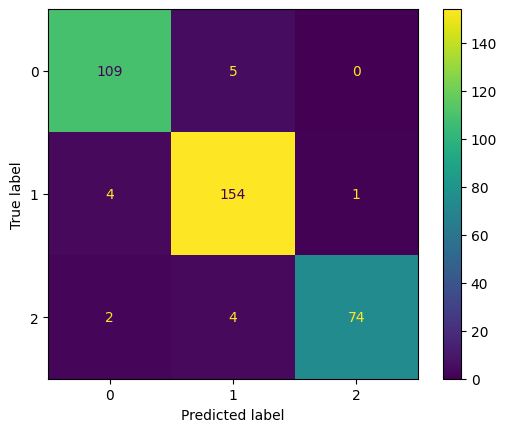

In [63]:
preds = best_model_SGD.predict(test_features)
cm = confusion_matrix(test_target, preds, labels=best_model_SGD.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_SGD.classes_)
disp.plot()
plt.show()

In [64]:
print('F1-мера модели SGDClassifier составила:', f1_score(test_target, preds, average='micro'))

F1-мера модели SGDClassifier составила: 0.9546742209631728


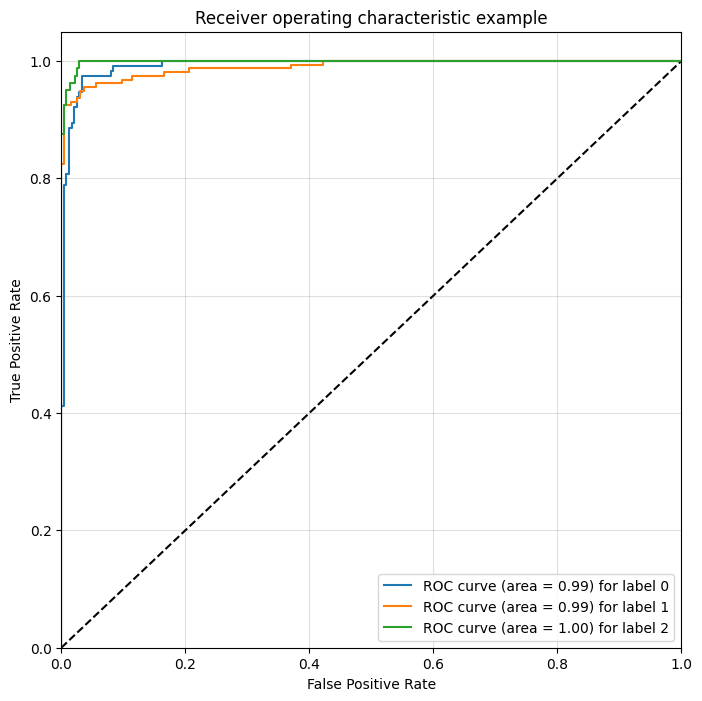

In [65]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(8, 8)):
    y_score = clf.decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # кривые для каждого класса
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

plot_multiclass_roc(best_model_SGD, test_features, test_target, n_classes=3, figsize=(8, 8))

Согласно документации scikit-learn, используем для сохранения модели pickle

In [66]:
filename = 'SGD_reviews_multiclass3.sav'
pickle.dump(best_model_SGD, open(filename, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

# Выводы:


1. Метрика f1 лучшей модели машинного обучения SGDClassifier на тестовой выборке составила 0.954 - близкую по значению к валидационной, что означает отсутствие переобучения.
2. Глубокое обучение на основе предобученной русскоязычной модели ruBERT + корректировка весов после fine-tune на тренеровочном датасете дало точно такой же результат - 0.954 ML
3. Вероятно, добиться большего результата на текущем датасете невозможно. Допускаю, что данные могли быть размечены с ошибкой либо датасета просто недостаточнобольшего значения не удается, вероятно по причине малого размера датасета.
4. Кривые ROC, построенные отдельно для каждого класса, имеют площадь практически максимальные площади: 0.99 0.99 1.00
5. Отдельно построены языковые представления через word2vec, а также рассмотрены уни- и би-граммы для классов